# Import Data

## Import the dataset

Import the dataset if you are in colab:

In [1]:
from google.colab import files
files.upload()
!ls

Saving completeDataset.csv to completeDataset.csv
completeDataset.csv  sample_data


Set the path to the csv file:

In [0]:
PATH_CSV = "completeDataset.csv"

## Function to import data

In [0]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

RANDOM_SHUFFLE_SEED = 22

#dataset
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

DF = pd.read_csv(PATH_CSV, header=0, delimiter=';')
DF['date'] = pd.to_datetime(DF['date'],utc=True)


def importData(nb_prev_measures_for_predict):
    print("=====IMPORT=====")

    features = DF[features_considered]
    features.index = DF['date']

    dataset_test = features.values

    def higher_value(features,i):
        return[row[i] for row in dataset_test]

    max_pressure = max(higher_value(dataset_test,1))
    max_wind_force = max(higher_value(dataset_test,3))
    max_temperature = max(higher_value(dataset_test, 5))

    #normalize
    features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
    features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
    features['humidity'] = features['humidity'].apply(lambda x: x/100)
    features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

    # IQ dummy  
    dummy = pd.get_dummies(features['IQ'])
    IQDummy = pd.DataFrame(columns = range(1,11,1))
    IQDummy[dummy.columns] = dummy.fillna(0)

    iqlist = list(range(1,11,1))
    for i,r in enumerate(iqlist):
        iqlist[i] = "IQ"+str(r)
    IQDummy.columns = iqlist

    #wind_direction to categorical
    dummy = pd.get_dummies(features['wind_direction'])
    windDummy = pd.DataFrame(columns = range(0,361,10))
    windDummy[dummy.columns] = dummy.fillna(0)

    features = pd.concat([features, windDummy, IQDummy], axis=1)
    features = features.drop(columns=["wind_direction","IQ"])

    features = features.fillna(0)

    x_train = []
    y_train = []
    countRow=0

    for indexRow, rowx in features.iterrows():
        # for each day we found with a value at 12:00
        if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
            try:
                # indexes for x (the range is inversed as our data are from the oldest to the newest)
                batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
                # indexes for y
                batchY = [countRow+8,countRow+16,countRow+24]

                #application
                y_train.append(features.iloc[batchY][iqlist].values)
                x_train.append(features.iloc[batchX].values)
            except:
                print("To long for ",indexRow)
        countRow+=1

    x_train,y_train = shuffle(x_train,y_train, random_state=RANDOM_SHUFFLE_SEED)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    y_train = y_train.reshape(y_train.shape[0],3,10)
    print("x_train :",x_train.shape)
    print("y_train :",y_train.shape)
    
    print("====END IMPORT====")
    return(x_train,y_train)

## Function to save the results

To save the results in a csv file:

In [4]:
!mkdir logs
!ls

completeDataset.csv  logs  sample_data


In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# code found here: https://stackoverflow.com/questions/42355122/can-i-export-a-tensorflow-summary-to-csv
import os
import numpy as np
import pandas as pd

import tensorflow as tf

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def tabulate_events(dpath):

    final_out = {}
    for dname in os.listdir(dpath):
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        out = {}

        for tag in tags:
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
                tag_values.append(event.value)
                wall_time.append(event.wall_time)
                steps.append(event.step)

            out[tag]=pd.DataFrame(data=dict(zip(steps,np.array([tag_values,wall_time]).transpose())), columns=steps,index=['value','wall_time'])

        if len(tags)>0:      
            df= pd.concat(out.values(),keys=out.keys())

        final_out[dname] = df


    return final_out

def saveProgressCSV():
  path = "logs/"
  steps = tabulate_events(path)
  pd.concat(steps.values(),keys=steps.keys()).to_csv('all_result.csv')

In [7]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'completeDataset.csv', 'logs', 'sample_data']


# Test differents models

##Librairies:

In [8]:
from keras.optimizers import RMSprop,Adam
from keras.callbacks import TensorBoard,EarlyStopping
from time import time
from keras.models import Model
from keras.layers import LSTM, Dense, Input, GRU, BatchNormalization, Dropout, Flatten
from keras.models import save_model
from datetime import datetime
from sklearn.model_selection import KFold

Using TensorFlow backend.


## Parameters:

In [0]:
# PARAMS TO TEST
EPOCHS = 100

## Main script

### Data

In [0]:
x_train,y_train = importData(32)
trainLength = int(len(x_train)*0.8)
x,x_val = x_train[:trainLength],x_train[trainLength:]
y,y_val = y_train[:trainLength],y_train[trainLength:]

### Manual script:

In [11]:
OPTI = "Adam"

# Model
input_shape = (x_train.shape[-2],x_train.shape[-1])
    
# Common part
inp = Input(input_shape,name='inputLayer')
_ = GRU(256,input_shape=input_shape,name='GRUcommonLayer1',return_sequences=True)(inp)
_ = Dropout(0.4,name="dropGRUcommon")(_)
_ = Dense(128,name='DensecommonLayer1')(_)
_ = Dropout(0.4,name="dropDensecommon")(_)

# 3 branches
outD1 = GRU(128,name="GRU1")(_)
outD1 = Dropout(0.4,name="drop1")(outD1)
    
outD2 = GRU(128,name="GRU2")(_)
outD2 = Dropout(0.4,name="drop2")(outD2)

outD3 = GRU(128,name="GRU3")(_)
outD3 = Dropout(0.4,name="drop3")(outD3)

# Output of each branch
outD1 = Dense(10,name="D1", activation='softmax')(outD1)
outD2 = Dense(10,name="D2", activation='softmax')(outD2)
outD3 = Dense(10,name="D3", activation='softmax')(outD3)
    
# compile Model
model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])   

LOSS = "categorical_crossentropy"
METRICS = ["accuracy"]
    
model.compile(optimizer=OPTI, loss={'D1': LOSS, 'D2': LOSS, 'D3': LOSS}, 
              metrics={'D1': METRICS, 'D2': METRICS, 'D3': METRICS})
model.summary()

#train:
hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,verbose=0)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputLayer (InputLayer)         (None, 32, 51)       0                                            
__________________________________________________________________________________________________
GRUcommonLayer1 (GRU)           (None, 32, 256)      236544      inputLayer[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 256)      0           GRUcommonLayer1[0][0]            
__________________________________________________________________________________________________
DensecommonLayer1 (Dense)       (None, 32, 128)      32896       dropo

### Show:

In [0]:
# display:
y_pred = model.predict(x_train)
y_out = []
for i in y_pred:
    y_out.append(np.argmax(i,axis=1))
y_out = np.array(y_out)+1

y_real = []
for i in range(3):
    y_real.append([])
    
for line in range(len(y_train)):
    for day in range(3):
        y_real[day].append(np.argmax(y_train[line][day]))
y_real = np.array(y_real)+1

Prediction of the air index quality


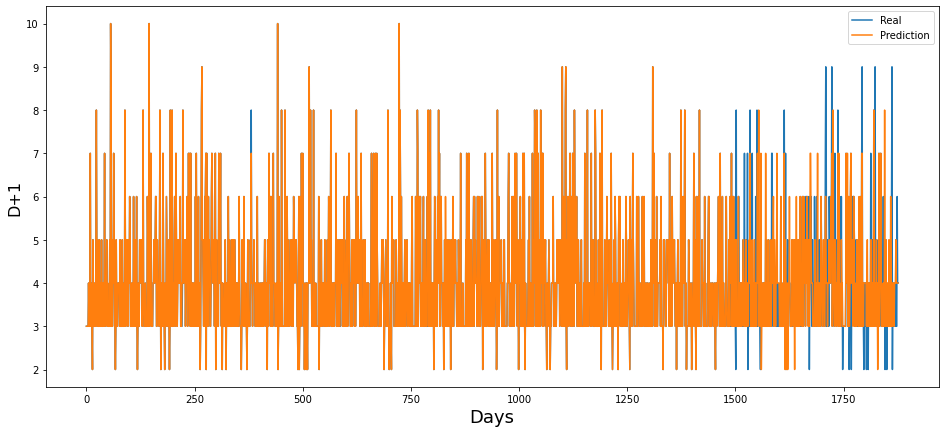

val_D1_loss 2.68226
val_D1_acc 0.59043
D1_loss 0.03744
D1_acc 0.98934


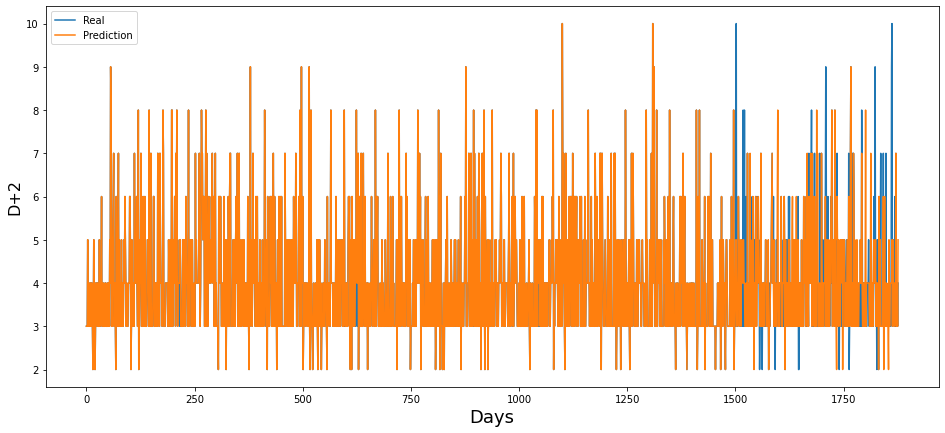

val_D2_loss 2.24391
val_D2_acc 0.6383
D2_loss 0.036
D2_acc 0.98934


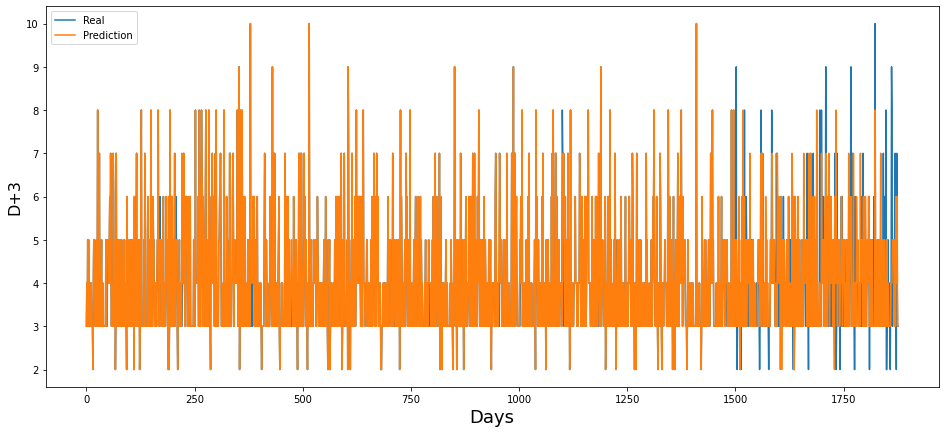

val_D3_loss 3.59468
val_D3_acc 0.51862
D3_loss 0.05589
D3_acc 0.98001


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16,7)

print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_real[plusDay], label='Real')
    plt.plot(y_out[plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))

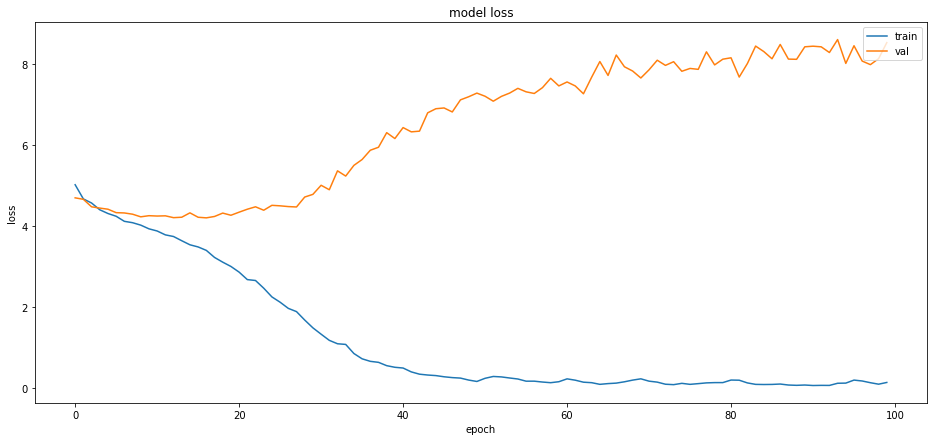

In [14]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

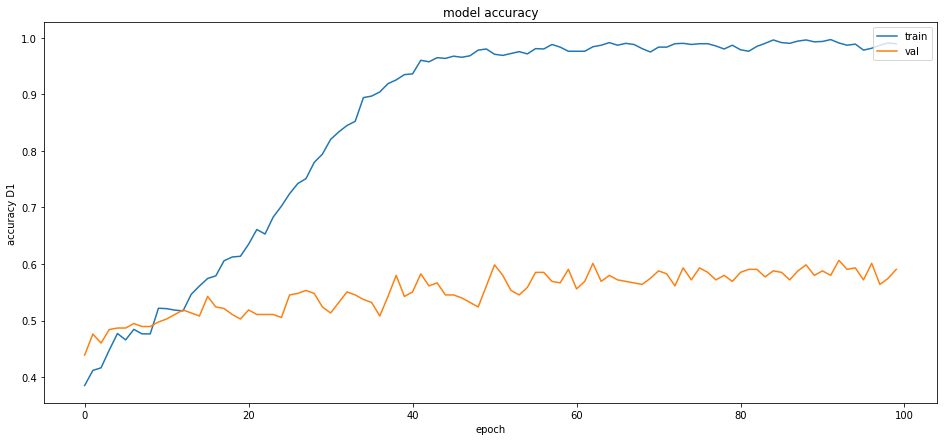

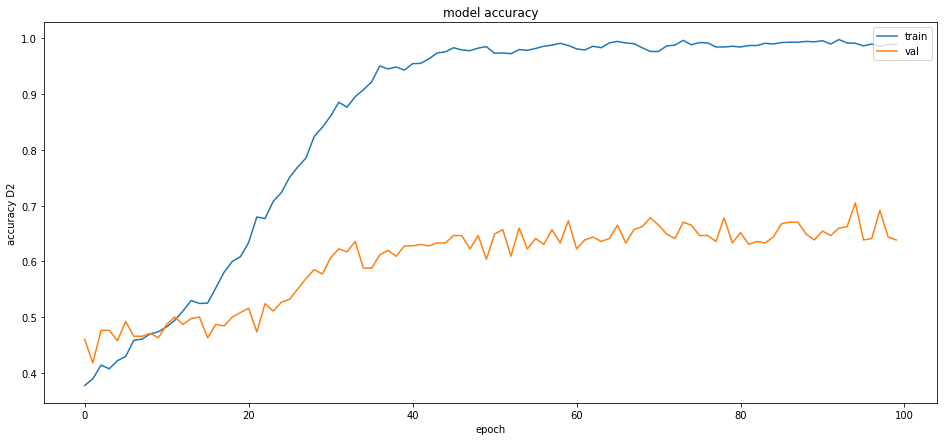

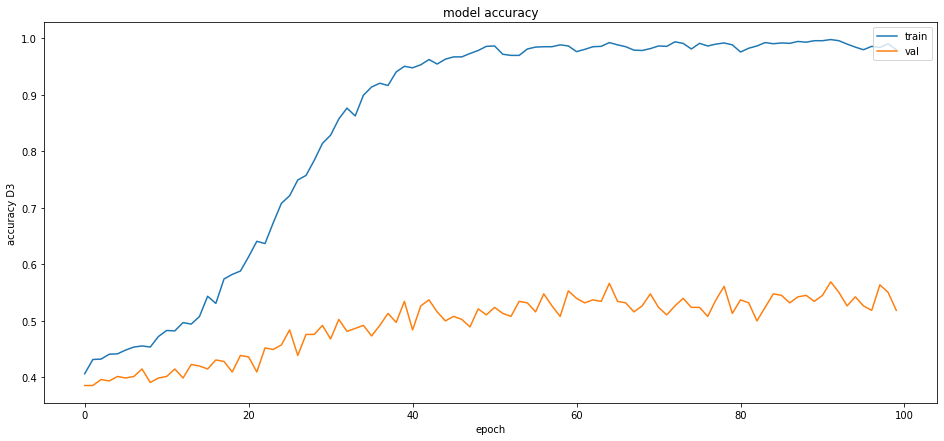

In [20]:
for i in range(1,4):
  # summarize history for accuracy D1
  plt.plot(hist.history[f'D{i}_acc'])
  plt.plot(hist.history[f'val_D{i}_acc'])
  plt.title('model accuracy')
  plt.ylabel(f'accuracy D{i}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()